In [1]:
import datetime
import json
import os
import sys
import pandas as pd
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split    
import dataframe_image as dfi
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

notebook_dir = os.path.abspath(os.getcwd())
src_path = os.path.join('/home/lerceg/LukaPosao/market_models/', 'src')
sys.path.append(src_path)

import market_models.src.models.train_model as tm
import market_models.src.models.predict_model as pm
import market_models.src.utils as utils

%load_ext autoreload
%autoreload 
import market_models.src.features.build_features as build_features


In [2]:
data_name = 'netrisk_casco_v18'
data_path = utils.get_processed_data_path(data_name)
features_path = utils.get_features_path(data_name)

data, features = utils.load_data(data_path, features_path, target_variable = 'ALFA_price')

isRecent bool
CarMake category
CarAge int64
ccm int64
kw int64
kg int64
car_value float64
CarMakerCategory float64
PostalCode int64
PostalCode2 int64
PostalCode3 int64
Category float64
Longitude float64
Latitude float64
Age int64
LicenseAge int64
BonusMalus category
BonusMalusCode int64
ALFA_postal_category int64
ALLIANZ_postal_category int64
GENERALI_postal_category int64
GENERTEL_postal_category int64
GROUPAMA_postal_category int64
K&AMP;H_postal_category int64
KÖBE_postal_category int64
MAGYAR_postal_category int64
SIGNAL_postal_category int64
UNION_postal_category int64
UNIQA_postal_category int64
WÁBERER_postal_category int64
ALFA_price_Age_cut category
ALLIANZ_price_Age_cut category
GENERALI_price_Age_cut category
GROUPAMA_price_Age_cut category
K&AMP;H_price_Age_cut category
KÖBE_price_Age_cut category
MAGYAR_price_Age_cut category
SIGNAL_price_Age_cut category
UNIQA_price_Age_cut category
Laoding data
['isRecent', 'CarMake', 'CarAge', 'ccm', 'kw', 'kg', 'car_value', 'CarMakerCa

In [3]:
data

,DateCrawled,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,CarMakerCategory,PostalCode,...,PostalCode3,Category,Longitude,Latitude,Age,LicenseAge,BonusMalus,BonusMalusCode,ALFA_price_Age_cut,ALFA_price
1,2024_01_02,True,28,2,998,49,899,15337.400,1.00,1011,...,101,2,19.0404,47.4984,35,18,0.0,1,3.0,175200.0
2,2024_01_02,True,66,1,1197,85,1390,25532.000,0.97,5200,...,520,6,20.4167,47.1833,35,18,0.0,1,3.0,167184.0
4,2024_01_02,True,5,2,1499,90,1545,30498.000,1.00,1011,...,101,2,19.0404,47.4984,35,18,0.0,1,3.0,400380.0
5,2024_01_02,True,66,1,1197,85,1390,25532.000,0.97,3770,...,377,6,20.7167,48.2167,35,18,0.0,1,3.0,167184.0
6,2024_01_02,True,66,1,1197,85,1390,25532.000,0.97,6791,...,679,7,20.1482,46.2530,35,18,0.0,1,3.0,203016.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9047,2024_01_23,True,56,4,999,59,1100,13945.776,1.00,8435,...,843,5,17.7525,47.4334,39,18,0.0,1,3.0,96744.0
9049,2024_01_23,True,66,5,998,53,1040,11791.000,0.97,4287,...,428,4,21.9000,47.5333,38,18,0.0,1,3.0,77448.0
9050,2024_01_23,True,28,4,998,88,1160,14817.400,1.00,4331,...,433,7,22.1754,47.8657,69,18,0.0,1,3.0,98496.0
9051,2024_01_23,True,58,5,999,44,1086,12697.620,1.00,9364,...,936,7,17.0288,47.4782,56,18,2.0,3,3.0,77904.0


In [111]:
pd.Interval('(17, 20]')

TypeError: __init__() takes at least 2 positional arguments (1 given)

In [4]:
data_name = 'netrisk_casco_v7'
target_variable = 'ALFA_price'
target_variable = 'GROUPAMA_price'
#target_variable = 'K&AMP;H_price'
target_variable = 'KÖBE_price'


data_path = utils.get_processed_data_path(data_name)
features_path = utils.get_features_path(data_name)



In [5]:
feature = ('BonusMalus')
data, features = utils.load_data(data_path, features_path, target_variable)
brackets = data.drop_duplicates([feature], keep='last')[[feature, target_variable]].sort_values(by = feature)
brackets = brackets.groupby(target_variable)[feature].agg(list)
brackets = brackets.reset_index(drop=True).reset_index()
brackets = brackets.rename(columns = {'index' : f'{target_variable}_{feature}_bracket'})
#brackets = brackets.explode(feature)
brackets

isRecent bool
CarMake category
CarAge int64
ccm int64
kw int64
kg int64
car_value float64
CarMakerCategory float64
PostalCode int64
PostalCode2 int64
PostalCode3 int64
Category float64
Longitude float64
Latitude float64
Age int64
LicenseAge int64
BonusMalus category
BonusMalusCode int64
ALFA_postal_category int64
ALLIANZ_postal_category int64
GENERALI_postal_category int64
GENERTEL_postal_category int64
GROUPAMA_postal_category int64
K&AMP;H_postal_category int64
KÖBE_postal_category int64
MAGYAR_postal_category int64
SIGNAL_postal_category int64
UNION_postal_category int64
UNIQA_postal_category int64
WÁBERER_postal_category int64
Laoding data
['isRecent', 'CarMake', 'CarAge', 'ccm', 'kw', 'kg', 'car_value', 'CarMakerCategory', 'PostalCode', 'PostalCode2', 'PostalCode3', 'Category', 'Longitude', 'Latitude', 'Age', 'LicenseAge', 'BonusMalus', 'BonusMalusCode', 'ALFA_postal_category', 'ALLIANZ_postal_category', 'GENERALI_postal_category', 'GENERTEL_postal_category', 'GROUPAMA_postal_cate

,KÖBE_price_BonusMalus_bracket,BonusMalus
0,0,"[1.0, 2.0, 3.0, 4.0, 5.0]"
1,1,[7.0]
2,2,[8.0]
3,3,[0.0]
4,4,[9.0]
5,5,[6.0]
6,6,[10.0]


In [6]:
data['DateCrawled'].value_counts()

2024_01_06    988
2024_01_05    976
2024_01_03    706
2024_01_02    674
Name: DateCrawled, dtype: int64

In [7]:
data[data['DateCrawled'] == '2024_01_02']['kw'].value_counts()

85     288
96      31
110     30
81      26
66      23
      ... 
126      1
108      1
130      1
134      1
127      1
Name: kw, Length: 68, dtype: int64

In [8]:
x = brackets.sort_values('Age').values[ : , 1].tolist()

KeyError: 'Age'

In [9]:
x

NameError: name 'x' is not defined

In [10]:
i = 0
cats = []
while i < len(x) - 1:
    if x[i] == [40] or x[i + 1] == [40]:
        i += 1
        continue
    cats.append(sorted(x[i] + x[i + 1]))
    i += 2

NameError: name 'x' is not defined

In [11]:
cats = [(min(x), max(x)) for x in cats]

In [12]:
cats

[]

In [13]:

def make_brackets(data, feature, target_variable):
    brackets = data.drop_duplicates([feature], keep='last')[[feature, target_variable]].sort_values(feature)
    brackets = brackets.groupby(target_variable)[feature].agg(list)
    brackets = brackets.reset_index(drop=True).reset_index()
    brackets = brackets.rename(columns = {'index' : f'{target_variable}_{feature}_bracket'})
    brackets = brackets.explode(feature)
    return brackets

def collapse_list(lst):
    return (min(lst), max(lst))

def merge_overlapping_tuples(tuple1, tuple2):
    start1, end1 = tuple1
    start2, end2 = tuple2

    # Check for overlap
    if start1 <= end2 and start2 <= end1:
        # Merge overlapping ranges
        merged_start = min(start1, start2)
        merged_end = max(end1, end2)
        return merged_start, merged_end
    else:
        # No overlap
        return None

    

In [12]:
brackets = make_brackets(data, target_variable, 'BonusMalus')
brackets

,Age_KÖBE_price_bracket,KÖBE_price
0,0,126270.0
0,0,132492.0
1,1,212280.0
2,2,79056.0
3,3,69906.0
3,3,82716.0
3,3,86376.0
3,3,87108.0
3,3,87474.0
3,3,88206.0


In [13]:
target_variables = ['ALFA_price', 'ALLIANZ_price', 'GENERALI_price', 'GENERTEL_price', 'GROUPAMA_price', 'K&AMP;H_price', 'KÖBE_price', 'MAGYAR_price', 'SIGNAL_price', 'UNION_price', 'UNIQA_price', 'WÁBERER_price']
for target_variable in target_variables:
    
    data, features = utils.load_data(data_path, features_path, target_variable)
    data_old = data[data['DateCrawled'] != '2024_01_05']
    
    for feature in ['Age', 'PostalCode']:
        brackets = make_brackets(data_old, target_variable, feature)
        brackets_dir = utils.get_feature_brackets_dir(target_variable)
        bracket_path = utils.get_brackets_path(target_variable, feature)
        print(bracket_path)

        brackets.to_csv(bracket_path, index = False)

../data/external/feature_brackets/ALFA_price_brackets/ALFA_price_Age_brackets.csv
../data/external/feature_brackets/ALFA_price_brackets/ALFA_price_PostalCode_brackets.csv
../data/external/feature_brackets/ALLIANZ_price_brackets/ALLIANZ_price_Age_brackets.csv
../data/external/feature_brackets/ALLIANZ_price_brackets/ALLIANZ_price_PostalCode_brackets.csv
../data/external/feature_brackets/GENERALI_price_brackets/GENERALI_price_Age_brackets.csv
../data/external/feature_brackets/GENERALI_price_brackets/GENERALI_price_PostalCode_brackets.csv
../data/external/feature_brackets/GENERTEL_price_brackets/GENERTEL_price_Age_brackets.csv
../data/external/feature_brackets/GENERTEL_price_brackets/GENERTEL_price_PostalCode_brackets.csv
../data/external/feature_brackets/GROUPAMA_price_brackets/GROUPAMA_price_Age_brackets.csv
../data/external/feature_brackets/GROUPAMA_price_brackets/GROUPAMA_price_PostalCode_brackets.csv
../data/external/feature_brackets/K&AMP;H_price_brackets/K&AMP;H_price_Age_brackets.c

In [14]:
brackets = make_brackets(data_new, 'CarAge', target_variable)

NameError: name 'data_new' is not defined

In [ ]:
brackets

In [15]:
make_brackets(data_new, 'PostalCode', target_variable)

NameError: name 'data_new' is not defined

In [16]:
make_brackets(data_new, 'Age', target_variable).apply(collapse_list)

NameError: name 'data_new' is not defined

In [17]:
make_brackets(data_old, 'Age', target_variable).apply(collapse_list)

,WÁBERER_price_Age_bracket,Age
0,0,35
1,1,40


In [18]:
import pandas as pd

# Sample data as a pandas Series
ranges = pd.concat([make_brackets(data_old, 'Age', target_variable), make_brackets(data_new, 'Age', target_variable)]).apply(collapse_list)

# Sort the series by the start value of each tuple
sorted_data = ranges.sort_values()

# Initialize variables to store merged ranges
merged_ranges = []

# Iterate through the tuples and merge overlapping ranges
current_start, current_end = sorted_data.iloc[0]

for index, value in sorted_data.iteritems():
    if value[0] <= current_end:
        # Merge overlapping ranges
        current_end = max(current_end, value[1])
    else:
        # Save the merged range and update current start and end
        merged_ranges.append((current_start, current_end))
        current_start, current_end = value

# Save the last merged range
merged_ranges.append((current_start, current_end))

# Create a new Series with merged ranges
result_series = pd.Series(merged_ranges, name='merged_ranges')

print(result_series)


NameError: name 'data_new' is not defined

In [19]:
data = pd.read_csv(utils.get_processed_data_path('netrisk_casco_v1'))

In [20]:
price_cols = data.filter(like = '_price').columns.to_list()
insurers = [x.replace('_price', '') for x in price_cols]

def add_rank(row):
    prices = list(zip(insurers, row[price_cols]))
    prices = sorted(prices, key=lambda x: float('inf') if str(x[1]) == 'nan' else x[1])
    ranks = []
    for i, (ins, pr) in enumerate(prices):
        if str(pr) != 'nan':
            ranks.append((ins, i + 1))
        else:
            ranks.append((ins, None))
    ranks = sorted(ranks, key=lambda x: x[0])
    return pd.Series([x[1] for x in ranks])

rank_cols = [ins + '_rank' for ins in insurers]
data[rank_cols] = data.apply(lambda x: add_rank(x), axis=1)


In [21]:
data[rank_cols]

,ALFA_rank,ALLIANZ_rank,GENERALI_rank,GENERTEL_rank,GROUPAMA_rank,K&AMP;H_rank,KÖBE_rank,MAGYAR_rank,SIGNAL_rank,UNION_rank,UNIQA_rank,WÁBERER_rank
0,6.0,9.0,5.0,NaN,3.0,8.0,2.0,NaN,NaN,1.0,4.0,7.0
1,3.0,8.0,10.0,NaN,2.0,4.0,5.0,6.0,11.0,1.0,9.0,7.0
2,7.0,9.0,10.0,NaN,6.0,8.0,3.0,2.0,11.0,5.0,1.0,4.0
3,6.0,9.0,4.0,NaN,11.0,8.0,3.0,2.0,10.0,1.0,7.0,5.0
4,6.0,10.0,7.0,NaN,3.0,9.0,1.0,2.0,8.0,5.0,11.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5190,7.0,4.0,5.0,NaN,3.0,9.0,1.0,NaN,NaN,2.0,6.0,8.0
5191,3.0,8.0,10.0,NaN,11.0,6.0,2.0,9.0,4.0,1.0,7.0,5.0
5192,3.0,9.0,5.0,NaN,7.0,8.0,1.0,4.0,NaN,2.0,6.0,NaN
5193,6.0,3.0,9.0,NaN,4.0,8.0,1.0,NaN,5.0,2.0,7.0,NaN


In [22]:
def rank_analysis(profiles):
    rank_value_counts = profiles[rank_cols].apply(pd.Series.value_counts)
    rank_percentage = rank_value_counts.apply(lambda x : x / x.sum(), axis = 1) * 100
    return rank_value_counts, rank_percentage

In [23]:
rank_value_counts, rank_percentage = rank_analysis(data)

In [24]:
rank_percentage.iloc[0 : 1]

,ALFA_rank,ALLIANZ_rank,GENERALI_rank,GENERTEL_rank,GROUPAMA_rank,K&AMP;H_rank,KÖBE_rank,MAGYAR_rank,SIGNAL_rank,UNION_rank,UNIQA_rank,WÁBERER_rank
1.0,5.928778,0.404235,1.732435,NaN,11.241578,0.250241,47.661213,6.12127,0.26949,16.053898,3.291627,7.045236


In [25]:
8000 / data['UNION_price'].mean() * 100

6.075722384836013

In [26]:
raw_data_name = 'netrisk_casco_2024_01_27'
raw_data_path = utils.get_raw_data_path(raw_data_name)
data = pd.read_csv(raw_data_path)

In [27]:
(data.sort_values('BonusMalusCode').set_index('BonusMalus').filter(like = '_price') / data.sort_values('BonusMalusCode').filter(like = '_price').iloc[0]).T

BonusMalus,B10,B9,B8,B7,B6,B5,B4,B2,B1,A0,M1,M2,M3,M4
ALFA_price,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
ALLIANZ_price,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
GENERALI_price,1.0,1.102566,1.102566,1.102566,1.153845,1.153845,1.153845,1.153845,1.153845,1.153845,1.153845,1.153845,1.153845,1.153845
GENERTEL_price,1.0,1.046874,1.156254,1.156254,1.156254,1.218753,1.218753,1.218753,1.281252,1.281252,NaN,NaN,NaN,NaN
GROUPAMA_price,1.0,1.142989,1.142989,1.142989,1.214345,1.214345,1.214345,1.285885,1.285885,1.357242,1.357242,1.357242,1.357242,1.357242
K&AMP;H_price,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
KÖBE_price,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.046961,1.113260,1.226519,1.292818,NaN,NaN,NaN,NaN
MAGYAR_price,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.794883,1.794883,1.794883,NaN,NaN,NaN,NaN
SIGNAL_price,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
UNION_price,1.0,1.000000,1.050132,1.117884,1.219512,1.321135,1.388887,1.388887,1.388887,1.388887,1.388887,1.388887,1.388887,1.388887


In [2]:
def collapse(x):
        if max(x) - min(x) + 1 == len(x):
            return min(x), max(x)
        else:
            return x
    
def load(raw_data_name = 'netrisk_casco_2024_01_28'):
    raw_data_path = utils.get_raw_data_path(raw_data_name)
    data = pd.read_csv(raw_data_path).sort_values('Age').set_index('Age')
    
    
    x = data.filter(like = '_price') / data.filter(like = '_price').iloc[0]
    indexes_dict = {}
    for insurer in data.filter(like='_price').columns:
        indexes_list = [collapse(list(group_indexes)) for group_indexes in x.groupby(insurer).groups.values()]
        indexes_list = sorted(indexes_list, key = lambda x : x[0])
        indexes_dict[insurer] = (indexes_list)    
    return data, x, indexes_dict

In [36]:
data1, x1, indexes_dict1 = load(raw_data_name = 'netrisk_casco_2024_01_28')

In [37]:
data1

,id_case,DateCrawled,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,CarMakerCategory,...,GENERALI_price,GENERTEL_price,GROUPAMA_price,K&AMP;H_price,KÖBE_price,MAGYAR_price,SIGNAL_price,UNION_price,UNIQA_price,WÁBERER_price
Age,,,,,,,,,,,,,,,,,,,,,
18,2,2024_01_28,False,AUDI,3,999,81,1300,29775.564,1,...,430562.0,NaN,193368.0,581191.0,212280.0,664806.0,537795.0,NaN,338710.0,NaN
19,54,2024_01_28,False,AUDI,3,999,81,1300,29775.564,1,...,430562.0,NaN,193368.0,581191.0,212280.0,664806.0,537795.0,NaN,336208.0,NaN
20,31,2024_01_28,False,AUDI,3,999,81,1300,29775.564,1,...,430562.0,NaN,193368.0,581191.0,212280.0,664806.0,537795.0,NaN,326952.0,NaN
21,53,2024_01_28,False,AUDI,3,999,81,1300,29775.564,1,...,430562.0,NaN,193368.0,581191.0,212280.0,664806.0,537795.0,NaN,315194.0,NaN
22,5,2024_01_28,False,AUDI,3,999,81,1300,29775.564,1,...,430562.0,NaN,193368.0,581191.0,212280.0,664806.0,537795.0,NaN,305689.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,29,2024_01_28,False,AUDI,3,999,81,1300,29775.564,1,...,250003.0,NaN,170928.0,435893.0,110166.0,392840.0,328652.0,226666.0,290930.0,NaN
76,7,2024_01_28,False,AUDI,3,999,81,1300,29775.564,1,...,250003.0,NaN,170928.0,435893.0,110166.0,392840.0,328652.0,226666.0,299184.0,NaN
77,50,2024_01_28,False,AUDI,3,999,81,1300,29775.564,1,...,250003.0,NaN,170928.0,435893.0,110166.0,392840.0,328652.0,226666.0,299184.0,NaN


In [41]:
data1, x1, indexes_dict1 = load(raw_data_name = 'netrisk_casco_2024_01_28')
data2,  x2, indexes_dict2 = load('netrisk_casco_2024_01_29')
data3,  x3, indexes_dict2 = load('netrisk_casco_2024_01_31')
data4,  x4, indexes_dict2 = load('netrisk_casco_2024_01_32')


In [43]:
data1['ALFA_price'] / data2['ALFA_price']

Age
18    1.211756
19    1.211756
20    1.211756
21    1.211756
22    1.211756
        ...   
75    1.211775
76    1.211775
77    1.211775
78    1.211775
79    1.211775
Name: ALFA_price, Length: 62, dtype: float64

In [44]:
data3['ALFA_price'] / data4['ALFA_price']

Age
18    1.211786
19    1.211786
20    1.211786
21    1.211786
22    1.211786
        ...   
75    1.211734
76    1.211734
77    1.211734
78    1.211734
79    1.211734
Name: ALFA_price, Length: 62, dtype: float64

In [31]:
for insurer in indexes_dict1.keys():
    if indexes_dict1[insurer] != indexes_dict2[insurer]:
        print(insurer, indexes_dict1[insurer], indexes_dict2[insurer])

ALFA_price [(18, 24), (25, 29), (30, 34), (35, 79)] [(18, 24), (25, 29), (30, 34), [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79]]
ALLIANZ_price [(18, 19), (20, 22), (23, 29), (30, 30), (31, 39), (40, 43), (44, 59), (60, 69), (70, 72), (73, 79)] [(18, 19), [20, 22], [24, 25, 27, 28, 29], (30, 30), [31, 32, 33, 34, 35, 36, 37, 39], (40, 43), [46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59], [60, 61, 62, 63, 65, 66, 67, 68, 69], (71, 72), (73, 79)]
GENERALI_price [(18, 22), (23, 29), (30, 33), (34, 39), (40, 69), (70, 77), (78, 79)] [(18, 22), (23, 29), (30, 33), (34, 39), (40, 69), (71, 77), (78, 79)]
GROUPAMA_price [(18, 25), (26, 30), (31, 35), (36, 40), (41, 45), (46, 50), (51, 55), (56, 60), (61, 65), (66, 70), (71, 79)] [(18, 25), (26, 30), (31, 35), (36, 40), (41, 45), (46, 50), (51, 55), (56, 60), (61, 65), (66, 69), (71, 79)]
K&AMP;H_price [(18, 2

In [32]:
data2

,id_case,DateCrawled,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,CarMakerCategory,...,GENERALI_price,GENERTEL_price,GROUPAMA_price,K&AMP;H_price,KÖBE_price,MAGYAR_price,SIGNAL_price,UNION_price,UNIQA_price,WÁBERER_price
Age,,,,,,,,,,,,,,,,,,,,,
18,2,2024_01_31,False,FIAT,3,875,63,1165,14664.0,0.97,...,266695.0,NaN,127272.0,332546.0,207156.0,NaN,264531.0,NaN,205635.0,NaN
19,53,2024_01_31,False,FIAT,3,875,63,1165,14664.0,0.97,...,266695.0,NaN,127272.0,332546.0,207156.0,NaN,264531.0,NaN,204116.0,NaN
20,30,2024_01_31,False,FIAT,3,875,63,1165,14664.0,0.97,...,266695.0,NaN,127272.0,332546.0,207156.0,NaN,264531.0,NaN,198497.0,NaN
21,52,2024_01_31,False,FIAT,3,875,63,1165,14664.0,0.97,...,266695.0,NaN,127272.0,332546.0,207156.0,NaN,264531.0,NaN,191359.0,NaN
22,5,2024_01_31,False,FIAT,3,875,63,1165,14664.0,0.97,...,266695.0,NaN,127272.0,332546.0,207156.0,NaN,264531.0,NaN,185588.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,28,2024_01_31,False,FIAT,3,875,63,1165,14664.0,0.97,...,154855.0,NaN,112500.0,249410.0,107604.0,NaN,161658.0,83149.0,176627.0,NaN
76,7,2024_01_31,False,FIAT,3,875,63,1165,14664.0,0.97,...,154855.0,NaN,112500.0,249410.0,107604.0,NaN,161658.0,83149.0,181639.0,NaN
77,49,2024_01_31,False,FIAT,3,875,63,1165,14664.0,0.97,...,154855.0,NaN,112500.0,249410.0,107604.0,NaN,161658.0,83149.0,181639.0,NaN


In [40]:
data1['ALFA_price'] / data2['ALFA_price']

Age
18    1.211756
19    1.211756
20    1.211756
21    1.211756
22    1.211756
        ...   
75    1.211775
76    1.211775
77    1.211775
78    1.211775
79    1.211775
Name: ALFA_price, Length: 62, dtype: float64

In [25]:
data1['ALFA_price'] / data2['ALFA_price']

Age
18    2.233319
19    2.233319
20    2.233319
21         NaN
22    2.233319
        ...   
75    2.233312
76    2.233312
77    2.233312
78    2.233312
79    2.233312
Name: ALFA_price, Length: 62, dtype: float64

In [33]:
data2['ALFA_price'] / data1['ALFA_price']

Age
18    0.825249
19    0.825249
20    0.825249
21    0.825249
22    0.825249
        ...   
75    0.825236
76    0.825236
77    0.825236
78    0.825236
79    0.825236
Name: ALFA_price, Length: 62, dtype: float64

In [9]:
indexes_dict

{'ALFA_price': [(18, 24),
  (25, 29),
  (30, 34),
  [35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79]],
 'ALLIANZ_price': [(18, 19),
  [20, 22],
  [24, 25, 27, 28, 29],
  (30, 30),
  [31, 32, 33, 34, 35, 36, 37, 39],
  (40, 43),
  [46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59],
  [60, 61, 62, 63, 65, 66, 67, 68, 69],
  (71, 72),
  (73, 79)],
 'GENERALI_price': [(18, 22),
  (23, 29),
  (30, 33),
  (34, 39),
  (40, 69),
  (71, 77),
  (78, 79)],
 'GENERTEL_price': [],
 'GROUPAMA_price': [(18, 25),
  (26, 30),
  (31, 35),
  (36, 40),
  (41, 45),
  (46, 50),
  (51, 55),
  (56, 60),
  (61, 65),
  (66, 69),
  (71, 79)],
 'K&AMP;H_price': [(18, 25),
  (26, 30),
  (31, 35),
  (36, 45),
  (46, 50),
  (51, 55),
  (56, 60),
  (61, 65),
  (6

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
import joblib

for insurer in data.filter(like = '_price'):
    print(insurer)
    encoder = OrdinalEncoder(unknown_value = np.nan, handle_unknown = 'use_encoded_value')
    bins = [interval[0] - 1 for interval in indexes_dict[insurer]] + [indexes_dict['ALFA_price'][-1][1]]
    encoder.fit_transform(pd.cut(data.reset_index()['Age'], bins = bins).values.reshape(-1, 1))
    print(f'{insurer}_Age_cut_encoder.pkl')
    print(encoder.categories_)
    joblib.dump(encoder, utils.get_encoder_path(f'{insurer}_Age_cut'))

In [11]:
data = pd.read_csv(utils.get_raw_data_path('netrisk_casco_2024_01_33'))

In [12]:
data = pd.read_csv(utils.get_raw_data_path('netrisk_casco_2024_01_33'))
data.sort_values('PostalCode').groupby('GROUPAMA_price')['PostalCode'].agg(list).apply(len)

GROUPAMA_price
99108.0      20
103872.0     60
108240.0    124
112608.0     97
116976.0    125
121464.0     79
125832.0     54
130332.0     53
139200.0     66
151776.0     36
Name: PostalCode, dtype: int64

In [13]:
data

,id_case,DateCrawled,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,CarMakerCategory,...,GENERALI_price,GENERTEL_price,GROUPAMA_price,K&AMP;H_price,KÖBE_price,MAGYAR_price,SIGNAL_price,UNION_price,UNIQA_price,WÁBERER_price
0,0,2024_01_33,False,AUDI,3,999,81,1300,29775.564,1,...,191322.0,NaN,116976.0,348732.0,88206.0,169979.0,199183.0,177391.0,166140.0,NaN
1,1,2024_01_33,False,AUDI,3,999,81,1300,29775.564,1,...,191322.0,NaN,112608.0,348732.0,88206.0,169979.0,199183.0,177391.0,180959.0,NaN
2,2,2024_01_33,False,AUDI,3,999,81,1300,29775.564,1,...,191322.0,NaN,139200.0,328601.0,95526.0,151092.0,199183.0,167536.0,208719.0,NaN
3,3,2024_01_33,False,AUDI,3,999,81,1300,29775.564,1,...,191322.0,NaN,108240.0,354474.0,90036.0,188865.0,199183.0,177391.0,208719.0,NaN
4,4,2024_01_33,False,AUDI,3,999,81,1300,29775.564,1,...,171183.0,NaN,121464.0,339466.0,79056.0,169979.0,199183.0,177391.0,194317.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,712,2024_01_33,False,AUDI,3,999,81,1300,29775.564,1,...,171183.0,NaN,108240.0,331436.0,90036.0,188865.0,199183.0,167536.0,180959.0,NaN
713,713,2024_01_33,False,AUDI,3,999,81,1300,29775.564,1,...,231600.0,NaN,139200.0,363376.0,132492.0,226638.0,328652.0,197101.0,254012.0,NaN
714,714,2024_01_33,False,AUDI,3,999,81,1300,29775.564,1,...,181253.0,NaN,116976.0,339466.0,79056.0,169979.0,199183.0,177391.0,166140.0,NaN
715,715,2024_01_33,False,AUDI,3,999,81,1300,29775.564,1,...,191322.0,NaN,116976.0,348732.0,88206.0,169979.0,199183.0,177391.0,166140.0,NaN


In [8]:
data

,id_case,DateCrawled,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,CarMakerCategory,...,GENERALI_price,GENERTEL_price,GROUPAMA_price,K&AMP;H_price,KÖBE_price,MAGYAR_price,SIGNAL_price,UNION_price,UNIQA_price,WÁBERER_price
0,0,2024_01_34,False,FIAT,3,875,63,1165,14664.0,0.97,...,118507.0,NaN,76992.0,199538.0,88206.0,NaN,97974.0,65073.0,110979.0,NaN
1,1,2024_01_34,False,FIAT,3,875,63,1165,14664.0,0.97,...,118507.0,NaN,71232.0,202823.0,82716.0,NaN,97974.0,65073.0,139421.0,NaN
2,2,2024_01_34,False,FIAT,3,875,63,1165,14664.0,0.97,...,106033.0,NaN,79944.0,194236.0,79056.0,NaN,97974.0,65073.0,129801.0,NaN
3,3,2024_01_34,False,FIAT,3,875,63,1165,14664.0,0.97,...,97301.0,NaN,71232.0,168621.0,82716.0,NaN,97974.0,61458.0,110979.0,NaN
4,4,2024_01_34,False,FIAT,3,875,63,1165,14664.0,0.97,...,106033.0,NaN,71232.0,182967.0,82716.0,NaN,97974.0,65073.0,169675.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,291,2024_01_34,False,FIAT,3,875,63,1165,14664.0,0.97,...,118507.0,NaN,79944.0,219498.0,82716.0,NaN,97974.0,61458.0,129801.0,NaN
292,292,2024_01_34,False,FIAT,3,875,63,1165,14664.0,0.97,...,118507.0,NaN,71232.0,182967.0,82716.0,NaN,97974.0,65073.0,98431.0,NaN
293,293,2024_01_34,False,FIAT,3,875,63,1165,14664.0,0.97,...,118507.0,NaN,82824.0,175627.0,82716.0,NaN,97974.0,61458.0,169675.0,NaN
294,294,2024_01_34,False,FIAT,3,875,63,1165,14664.0,0.97,...,106033.0,NaN,71232.0,189641.0,82716.0,NaN,97974.0,61458.0,120878.0,NaN


In [28]:
data = pd.read_csv(utils.get_raw_data_path('netrisk_casco_2024_01_33'))
insurers = data.filter(like = '_price').columns
feature = 'PostalCode'

cats = []
for insurer in insurers:
    x = data.sort_values(feature).groupby(insurer)[feature].agg(list).reset_index()
    #print(insurer, x[feature].apply(len).values)
    if len(x) == 0 or len(x) > 10:
        print(insurer)
        continue
    x[insurer] = x[insurer] / x[insurer].iloc[0]
    cats.append(x)
    
cats = [cat[feature].values.tolist() for cat in cats]

ALLIANZ_price
GENERALI_price
GENERTEL_price
K&AMP;H_price
UNIQA_price
WÁBERER_price


In [29]:
cats

[[[2065,
   2066,
   2067,
   2091,
   2421,
   2422,
   2424,
   2426,
   2431,
   2433,
   2451,
   2454,
   2457,
   2458,
   2459,
   2462,
   2463,
   2465,
   2471,
   2473,
   2475,
   2476,
   2481,
   2483,
   2484,
   2490,
   2509,
   2517,
   2519,
   2521,
   2523,
   2531,
   2532,
   2534,
   2536,
   2541,
   2643,
   2651,
   2659,
   2687,
   2831,
   2836,
   2837,
   2851,
   2870,
   2896,
   2898,
   2899,
   2900,
   2903,
   2911,
   2921,
   2941,
   2942,
   2943,
   3013,
   3014,
   3015,
   3016,
   3021,
   3023,
   3032,
   3035,
   3036,
   3047,
   3060,
   3063,
   3070,
   3121,
   3170,
   3182,
   3212,
   3214,
   3231,
   3245,
   3246,
   3250,
   3261,
   3281,
   3292,
   3324,
   3326,
   3346,
   3350,
   3351,
   3356,
   3358,
   3372,
   3384,
   3385,
   3388,
   3390,
   3396,
   3397,
   3399,
   3418,
   3432,
   3433,
   3434,
   3450,
   3458,
   3551,
   3553,
   3555,
   3561,
   3562,
   3564,
   3565,
   3571,
   3572,
   3574,
 

In [30]:
cats

[[[2065,
   2066,
   2067,
   2091,
   2421,
   2422,
   2424,
   2426,
   2431,
   2433,
   2451,
   2454,
   2457,
   2458,
   2459,
   2462,
   2463,
   2465,
   2471,
   2473,
   2475,
   2476,
   2481,
   2483,
   2484,
   2490,
   2509,
   2517,
   2519,
   2521,
   2523,
   2531,
   2532,
   2534,
   2536,
   2541,
   2643,
   2651,
   2659,
   2687,
   2831,
   2836,
   2837,
   2851,
   2870,
   2896,
   2898,
   2899,
   2900,
   2903,
   2911,
   2921,
   2941,
   2942,
   2943,
   3013,
   3014,
   3015,
   3016,
   3021,
   3023,
   3032,
   3035,
   3036,
   3047,
   3060,
   3063,
   3070,
   3121,
   3170,
   3182,
   3212,
   3214,
   3231,
   3245,
   3246,
   3250,
   3261,
   3281,
   3292,
   3324,
   3326,
   3346,
   3350,
   3351,
   3356,
   3358,
   3372,
   3384,
   3385,
   3388,
   3390,
   3396,
   3397,
   3399,
   3418,
   3432,
   3433,
   3434,
   3450,
   3458,
   3551,
   3553,
   3555,
   3561,
   3562,
   3564,
   3565,
   3571,
   3572,
   3574,
 

In [31]:
unpacked_cats = []
for cat in cats:
    for c in sorted(cat):
        unpacked_cats.append(c)

In [32]:
unpacked_cats = sorted(unpacked_cats, key = lambda x : (len(x), x[0]))

In [33]:
def solve_hitting_sets_approx(sets):
    
    solution = []
    covered = len(sets) * [False]
    covered_by = len(sets) * [None]
    id = 0
    
    while id < len(sets):
        
        if covered[id] == True:
            id += 1
            continue
        
        sett = sets[id]
        element = sett[0]
        solution.append(element)
        for j in range(len(sets)):
            if element in sets[j]:
                covered[j] = True
                covered_by[j] = element
                    
        id += 1
    
     
    print(sum(covered) / len(covered))
    return covered_by, sorted(solution)
    

In [34]:
[x[0] for x in unpacked_cats]

[2451,
 2067,
 6622,
 3013,
 1011,
 1021,
 6032,
 1021,
 2711,
 1011,
 3418,
 1051,
 2049,
 2072,
 2066,
 1051,
 1082,
 2014,
 2509,
 1011,
 1011,
 1011,
 2643,
 2014,
 2065,
 2534,
 1011,
 3418,
 3418,
 2021,
 2065,
 2016,
 2065,
 2014]

In [35]:
x, y = solve_hitting_sets_approx(unpacked_cats)

1.0


In [36]:
for i in range(len(unpacked_cats)):
    print(x[i], x[i] in unpacked_cats[i])

2451 True
2067 True
6622 True
3013 True
1011 True
1021 True
6032 True
1082 True
2711 True
2711 True
3418 True
2049 True
2049 True
2711 True
2066 True
1051 True
1082 True
2049 True
6622 True
1082 True
1082 True
1082 True
6032 True
2049 True
2067 True
3418 True
1082 True
3418 True
3418 True
2066 True
2066 True
2066 True
2066 True
2066 True


In [37]:
len(y)

13

In [39]:
y

[1011, 1021, 1051, 1082, 2049, 2066, 2067, 2451, 2711, 3013, 3418, 6032, 6622]

In [177]:
insurers

Index(['ALFA_price', 'ALLIANZ_price', 'GENERALI_price', 'GENERTEL_price',
       'GROUPAMA_price', 'K&AMP;H_price', 'KÖBE_price', 'MAGYAR_price',
       'SIGNAL_price', 'UNION_price', 'UNIQA_price', 'WÁBERER_price'],
      dtype='object')

In [114]:
import networkx as nx


def hamilton_cycle_from_list(vertices):
    G = nx.Graph()
    G.add_nodes_from(vertices)
    # Add edges to form a cycle
    for i in range(len(vertices)):
        G.add_edge(vertices[i], vertices[(i + 1) % len(vertices)])
    return G

vertices = data['PostalCode'].unique().tolist()

graph = nx.Graph(vertices = vertices)

for category in unpacked_cats:
    graph.add_edges_from(nx.complete_graph(category).edges())

In [74]:
graph.edges()

EdgeView([(2065, 2066), (2065, 9970), (2065, 4485), (2065, 2463), (2065, 9423), (2065, 2067), (2065, 9915), (2065, 8156), (2065, 2049), (2065, 2038), (2065, 1148), (2065, 2071), (2066, 2067), (2066, 2091), (2066, 2421), (2066, 9071), (2066, 2424), (2066, 9970), (2066, 1239), (2066, 2111), (9970, 9915), (9970, 5510), (9970, 9798), (9970, 2735), (9970, 9444), (9970, 9545), (9970, 3418), (9970, 2014), (9970, 2016), (9970, 1036), (9970, 9737), (2067, 2091), (2067, 2831), (2067, 5420), (2067, 2038), (2067, 2072), (2067, 2509), (2067, 2943), (2067, 2162), (2067, 2071), (2067, 1114), (2067, 2116), (2091, 2421), (2091, 2484), (2091, 2074), (2091, 2098), (2091, 2089), (2091, 2094), (2091, 2095), (2091, 2038), (2091, 2097), (2421, 2422), (2421, 8127), (2421, 2367), (2421, 2381), (2421, 2433), (2422, 2424), (2422, 2431), (2422, 2426), (2422, 2366), (2424, 2426), (2424, 7081), (2424, 2457), (2426, 2431), (2426, 2462), (2426, 8790), (2426, 2471), (2431, 2433), (2431, 2454), (2431, 2373), (2433, 245

In [116]:
import dwave_networkx as dnx
import dimod
sampler = dimod.ExactSolver()  # small testing sampler
G = dnx.chimera_graph(1, 1, 4)
G.remove_node(7)  # to give a unique solution
dnx.min_vertex_cover(graph, sampler, lagrange=2.0)

ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

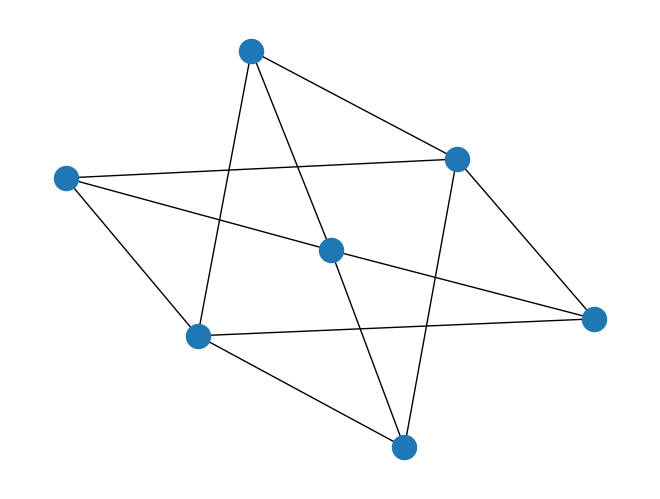

In [68]:
nx.draw(G)

In [32]:
cars = pd.read_csv(f'{utils.get_others_path("netrisk_casco")}full_trim_list.csv')
prices = pd.read_csv(f'{utils.get_others_path("netrisk_casco")}price.csv')[['eurotax_code', 'new_price_1_gross']].rename(columns={'new_price_1_gross': 'car_value'})
cars = pd.merge(cars, prices, on = 'eurotax_code', how = 'inner')

/tmp/ipykernel_38726/2476937825.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  cars = pd.read_csv(f'{utils.get_others_path("netrisk_casco")}full_trim_list.csv')


In [33]:
cars[cars.duplicated(subset = ['car_value'])]

,vehicle_type,production_code,product_name,manufacturer_switch_code,model_series_name_1,model_series_code,start_of_production,end_of_production,eurotax_code,type_name,...,performance,fuel,number_of_doors,cylinder_capacity,total_weight,own_crowd_with_driver,number_of_seats,full_name,fuel_short,car_value
16,10,1,ABARTH,1,595,1004,2016,NaN,0103B007,1.4 T-Jet 160 PISTA,...,118.0,Benzin ólommentes,3,1368.0,1385,1035,4,ABARTH_595_1.4 T-Jet 160 PISTA,O,6480000.0
23,10,1,ABARTH,1,595,1004,2016,NaN,0103B003,1.4 T-Jet 165 Turismo,...,121.0,Benzin ólommentes,3,1368.0,1385,1035,4,ABARTH_595_1.4 T-Jet 165 Turismo,O,6630000.0
30,10,1,ABARTH,1,595,1004,2016,NaN,0103B018,1.4 T-Jet 165 PISTA Dualogic,...,121.0,Benzin ólommentes,3,1368.0,1385,1035,4,ABARTH_595_1.4 T-Jet 165 PISTA Dualogic,O,6740000.0
33,10,1,ABARTH,1,595,1004,2016,NaN,0103B005,1.4 T-Jet 180 Competizione,...,132.0,Benzin ólommentes,3,1368.0,1385,1035,4,ABARTH_595_1.4 T-Jet 180 Competizione,O,7530000.0
44,10,1,ABARTH,1,595C,1003,2016,NaN,0104B009,1.4 T-Jet 145,...,107.0,Benzin ólommentes,2,1368.0,1385,1035,4,ABARTH_595C_1.4 T-Jet 145,O,6630000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123463,30,285,SWM,285,Motorkerékpár [126 - 500 ccm között],285015,2019,NaN,85300017,Grand Milano Outlaw 500,...,22.0,Benzin,0,445.0,0,145,0,SWM_Motorkerékpár [126 - 500 ccm között]_Grand...,O,1975000.0
123464,30,285,SWM,285,Motorkerékpár [501 - 900 ccm között],285020,2019,2021.0,85300012,Superdual 650 X,...,40.0,Benzin,0,600.0,0,187,0,SWM_Motorkerékpár [501 - 900 ccm között]_Super...,O,2670000.0
123465,30,285,SWM,285,Motorkerékpár [501 - 900 ccm között],285020,2019,2021.0,85300019,Superdual T,...,40.0,Benzin,0,600.0,0,187,0,SWM_Motorkerékpár [501 - 900 ccm között]_Super...,O,2670000.0
123466,30,220,ENERGICA,220,Motorkerékpár [ 0 - 125 ccm között],220010,2020,NaN,20300001,EGO+,...,107.0,Elektromos,0,0.0,0,0,0,ENERGICA_Motorkerékpár [ 0 - 125 ccm között]_EGO+,E,10780000.0


In [28]:
cars

,vehicle_type,production_code,product_name,manufacturer_switch_code,model_series_name_1,model_series_code,start_of_production,end_of_production,eurotax_code,type_name,model_series_switch_code,performance,fuel,number_of_doors,cylinder_capacity,total_weight,own_crowd_with_driver,number_of_seats,full_name,fuel_short
0,10,1,ABARTH,1,500,1008,2008,2016.0,01Z1B001,1.4,1008,99.0,Benzin ólommentes,3,1368.0,1720,1035,4,ABARTH_500_1.4,O
1,10,1,ABARTH,1,500,1008,2008,2016.0,01Z1B002,1.4,1008,99.0,Benzin ólommentes,3,1368.0,1425,1035,4,ABARTH_500_1.4,O
2,10,1,ABARTH,1,595,1010,2008,2016.0,01Z2B004,1.4 T-Jet Turismo,1010,118.0,Benzin ólommentes,3,1368.0,1720,1330,4,ABARTH_595_1.4 T-Jet Turismo,O
3,10,1,ABARTH,1,595,1010,2008,2016.0,01Z2B001,1.4 T-Jet Turismo Aut.,1010,118.0,Benzin ólommentes,3,1368.0,1400,1045,4,ABARTH_595_1.4 T-Jet Turismo Aut.,O
4,10,1,ABARTH,1,595,1010,2008,2016.0,01Z2B005,1.4 T-Jet Competizione,1010,118.0,Benzin ólommentes,3,1368.0,1425,1035,4,ABARTH_595_1.4 T-Jet Competizione,O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131263,30,320,RAP,320,ATV / Quad / Áruszállító,320090,2023,NaN,12300020,Bange Van Box,320090,5.0,Elektromos,0,0.0,380,130,0,RAP_ATV / Quad / Áruszállító_Bange Van Box,E
131264,30,320,RAP,320,ATV / Quad / Áruszállító,320090,2023,NaN,12300021,Bange Refrigerated model,320090,5.0,Elektromos,0,0.0,380,130,0,RAP_ATV / Quad / Áruszállító_Bange Refrigerate...,E
131265,30,320,RAP,320,ATV / Quad / Áruszállító,320090,2023,NaN,12300022,Bange Pick Up,320090,5.0,Elektromos,0,0.0,380,130,0,RAP_ATV / Quad / Áruszállító_Bange Pick Up,E
131266,30,320,RAP,320,ATV / Quad / Áruszállító,320090,2023,NaN,12300023,Oak L2e Van Box,320090,4.0,Elektromos,0,0.0,430,380,0,RAP_ATV / Quad / Áruszállító_Oak L2e Van Box,E


In [38]:
cars[(cars['product_name'] == 'AUDI') & (cars['start_of_production'] > 2015)]

,vehicle_type,production_code,product_name,manufacturer_switch_code,model_series_name_1,model_series_code,start_of_production,end_of_production,eurotax_code,type_name,...,performance,fuel,number_of_doors,cylinder_capacity,total_weight,own_crowd_with_driver,number_of_seats,full_name,fuel_short,car_value
864,10,5,AUDI,5,A1 Sportback,5282,2018,NaN,056EB007,25 TFSI Basis,...,70.0,Benzin ólommentes,5,999.0,1630,1165,5,AUDI_A1 Sportback_25 TFSI Basis,O,6500410.0
865,10,5,AUDI,5,A1 Sportback,5282,2018,NaN,056EB014,25 TFSI Basis S-tronic,...,70.0,Benzin ólommentes,5,999.0,1705,1200,5,AUDI_A1 Sportback_25 TFSI Basis S-tronic,O,7179860.0
866,10,5,AUDI,5,A1 Sportback,5282,2018,NaN,056EB008,25 TFSI Advanced,...,70.0,Benzin ólommentes,5,999.0,1630,1165,4,AUDI_A1 Sportback_25 TFSI Advanced,O,6955070.0
867,10,5,AUDI,5,A1 Sportback,5282,2018,NaN,056EB015,25 TFSI Advanced S-tronic,...,70.0,Benzin ólommentes,5,999.0,1705,1200,5,AUDI_A1 Sportback_25 TFSI Advanced S-tronic,O,7635790.0
868,10,5,AUDI,5,A1 Sportback,5282,2018,NaN,056EB009,25 TFSI S line,...,70.0,Benzin ólommentes,5,999.0,1630,1165,4,AUDI_A1 Sportback_25 TFSI S line,O,7372900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5332,10,5,AUDI,5,e-tron Sportback,5304,2020,NaN,0502M005,55 Advanced quattro Aut.,...,300.0,Áram (Elektromos),5,0.0,3150,2555,5,AUDI_e-tron Sportback_55 Advanced quattro Aut.,E,33403540.0
5333,10,5,AUDI,5,e-tron Sportback,5304,2020,NaN,0502M011,55 Advanced Xtra quattro Aut.,...,300.0,Áram (Elektromos),5,0.0,3150,2555,5,AUDI_e-tron Sportback_55 Advanced Xtra quattro...,E,32066230.0
5334,10,5,AUDI,5,e-tron Sportback,5304,2020,NaN,0502M006,55 S line quattro Aut.,...,300.0,Áram (Elektromos),5,0.0,3150,2555,5,AUDI_e-tron Sportback_55 S line quattro Aut.,E,34085530.0
5335,10,5,AUDI,5,e-tron Sportback,5304,2020,NaN,0502M012,55 S line Xtra quattro Aut.,...,300.0,Áram (Elektromos),5,0.0,3150,2555,5,AUDI_e-tron Sportback_55 S line Xtra quattro Aut.,E,32659320.0


In [52]:
cars[(cars['start_of_production'] > 2015) & (cars['car_value'] == 8599000)]

,vehicle_type,production_code,product_name,manufacturer_switch_code,model_series_name_1,model_series_code,start_of_production,end_of_production,eurotax_code,type_name,...,performance,fuel,number_of_doors,cylinder_capacity,total_weight,own_crowd_with_driver,number_of_seats,full_name,fuel_short,car_value
12633,10,17,CITROEN,17,C4 Dies,17204,2020,NaN,1758D001,1.5 BlueHDi Feel EAT8,...,96.0,Diesel,5,1499.0,1795,1324,5,CITROEN_C4 Dies_1.5 BlueHDi Feel EAT8,D,8599000.0
21036,10,30,HONDA,30,Civic,30087,2017,2019.0,3056B012,1.5 T Sport Plus CVT,...,134.0,Benzin ólommentes,5,1498.0,1790,1340,5,HONDA_Civic_1.5 T Sport Plus CVT,O,8599000.0
21661,10,32,HYUNDAI,32,Bayon,32136,2021,NaN,3277B008,1.0 T-GDI LP Comfort DCT,...,74.0,Benzin ólommentes,5,998.0,1660,1120,5,HYUNDAI_Bayon_1.0 T-GDI LP Comfort DCT,O,8599000.0
21668,10,32,HYUNDAI,32,Bayon,32136,2021,NaN,3277B013,1.0 T-GDI LP Comfort MHEV,...,74.0,Benzin ólommentes,5,998.0,1660,1120,5,HYUNDAI_Bayon_1.0 T-GDI LP Comfort MHEV,O,8599000.0
21782,10,32,HYUNDAI,32,Kona Dies,32134,2020,2021.0,3281D005,1.6 CRDi MHEV Premium DCT,...,100.0,Diesel,5,1598.0,1895,1370,5,HYUNDAI_Kona Dies_1.6 CRDi MHEV Premium DCT,D,8599000.0
22377,10,32,HYUNDAI,32,i30,32126,2020,NaN,3273B013,1.5 T-GDi Comfort MHEV,...,118.0,Benzin ólommentes,5,1482.0,1830,1250,5,HYUNDAI_i30_1.5 T-GDi Comfort MHEV,O,8599000.0
22445,10,32,HYUNDAI,32,i30 Kombi,32128,2020,NaN,3274B027,1.5 DPi Prime,...,81.0,Benzin ólommentes,5,1498.0,1800,1206,5,HYUNDAI_i30 Kombi_1.5 DPi Prime,O,8599000.0
22452,10,32,HYUNDAI,32,i30 Kombi Dies,32129,2020,2021.0,3274D007,1.6 CRDi HP Comfort MHEV,...,100.0,Diesel,5,1598.0,1920,1340,5,HYUNDAI_i30 Kombi Dies_1.6 CRDi HP Comfort MHEV,D,8599000.0
22460,10,32,HYUNDAI,32,i30 Fastback,32130,2020,NaN,3275B005,1.0 T-GDi Comfort MHEV,...,88.0,Benzin ólommentes,5,998.0,1820,1252,5,HYUNDAI_i30 Fastback_1.0 T-GDi Comfort MHEV,O,8599000.0
22484,10,32,HYUNDAI,32,i30 Fastback Dies,32131,2020,2021.0,3275D002,1.6 CRDi HP Life MHEV DCT,...,100.0,Diesel,5,1598.0,1930,1365,5,HYUNDAI_i30 Fastback Dies_1.6 CRDi HP Life MHE...,D,8599000.0


In [43]:
cars[cars['start_of_production'] > 2015]['car_value'].value_counts()

8599000.0     30
8249000.0     27
7449000.0     26
8549000.0     26
8649000.0     25
              ..
17409000.0     1
16467000.0     1
15726000.0     1
18542200.0     1
14588870.0     1
Name: car_value, Length: 19632, dtype: int64

In [3]:
data = pd.read_csv(utils.get_raw_data_path('netrisk_casco_2024_02_09'))
insurers = data.filter(like = '_price').columns
feature = 'PostalCode'


In [5]:
data['PostalCode']

0       9555
1       7753
2       2881
3       6446
4       4834
        ... 
2666    6781
2667    6335
2668    2943
2669    7957
2670    2300
Name: PostalCode, Length: 2671, dtype: int64

In [ ]:
population['']

In [13]:
signal_casco_postal_codes = pd.read_excel('../../signal_casco_tariff/input/signal_casco_postal_codes.xlsx')
set(signal_casco_postal_codes.iloc[ : , 0]).difference(data['PostalCode'])

{1028,
 1036,
 1088,
 1103,
 1529,
 2001,
 2002,
 2003,
 2012,
 2019,
 2026,
 2031,
 2032,
 2033,
 2035,
 2036,
 2041,
 2042,
 2043,
 2044,
 2046,
 2047,
 2052,
 2061,
 2063,
 2082,
 2087,
 2098,
 2099,
 2101,
 2102,
 2103,
 2105,
 2118,
 2121,
 2122,
 2123,
 2152,
 2153,
 2167,
 2201,
 2202,
 2221,
 2222,
 2242,
 2301,
 2311,
 2312,
 2313,
 2331,
 2332,
 2337,
 2341,
 2342,
 2343,
 2371,
 2372,
 2374,
 2401,
 2402,
 2403,
 2404,
 2405,
 2406,
 2407,
 2408,
 2421,
 2425,
 2427,
 2441,
 2442,
 2443,
 2444,
 2452,
 2453,
 2482,
 2485,
 2501,
 2503,
 2511,
 2512,
 2537,
 2542,
 2544,
 2601,
 2602,
 2603,
 2636,
 2661,
 2662,
 2683,
 2701,
 2702,
 2703,
 2704,
 2738,
 2751,
 2752,
 2761,
 2801,
 2802,
 2803,
 2804,
 2805,
 2806,
 2807,
 2808,
 2809,
 2841,
 2842,
 2891,
 2892,
 2893,
 2894,
 2901,
 2902,
 2904,
 2921,
 2922,
 2932,
 3001,
 3002,
 3003,
 3022,
 3024,
 3061,
 3062,
 3065,
 3071,
 3072,
 3078,
 3082,
 3101,
 3103,
 3104,
 3107,
 3109,
 3110,
 3137,
 3141,
 3144,
 3146,
 3147,

In [14]:
len(set(signal_casco_postal_codes.iloc[ : , 0]).difference(data['PostalCode']))

975

In [15]:
postal_codes = pd.read_csv(f'{utils.get_others_path("netrisk_casco")}hungary_postal_codes.csv')['postal_code']
population = pd.read_csv(f'{utils.get_others_path("netrisk_casco")}hungary_postal_codes_population.csv').rename(
    columns={'PostalCode': 'postal_code',
             'Population': 'population'})[['postal_code', 'population']]


def to_int(x):
    try:
        return int(str(x).replace(',', ''))
    except Exception as e:
        return None


population['population'] = population['population'].apply(to_int)
population = population.dropna()


In [31]:
len(set(population['postal_code']).difference(set(data['PostalCode'])))

2709

In [33]:
len(set(data['PostalCode']).difference(set(population['postal_code'])))

2656

In [30]:
population

,postal_code,population
1,1011,5052.0
2,1012,2905.0
3,1013,6066.0
4,1014,2594.0
5,1015,3407.0
...,...,...
3348,9962,1665.0
3349,9970,8130.0
3352,9982,512.0
3353,9983,705.0


In [26]:
population[population['population'] == 8313.0]

,postal_code,population


In [48]:
no_quotes = []
for postal_code in sorted(population['postal_code']):
    if int(postal_code) not in set(data['PostalCode']):
        no_quotes.append(int(postal_code))
    

In [49]:
no_quotes

[1028,
 1036,
 1088,
 1103,
 2098,
 2118,
 2167,
 2337,
 2371,
 2421,
 2425,
 2485,
 2544,
 2683,
 2921,
 3179,
 3244,
 3275,
 3354,
 3425,
 3515,
 3761,
 3817,
 3871,
 3898,
 3941,
 4090,
 4175,
 4254,
 4285,
 4456,
 4487,
 5094,
 5526,
 6346,
 6454,
 6723,
 7018,
 7042,
 7162,
 7257,
 7354,
 8066,
 8315,
 8651,
 8873,
 8929,
 8988,
 9030,
 9088,
 9324,
 9514,
 9798]